<a href="https://colab.research.google.com/github/PrithvirajKhelkar/intent-classification-shallow-ml/blob/main/intent_classification_shallow_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import required libraries

In [50]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
import matplotlib.pyplot as plt

## loads the train and test datasets from [here](https://www.kaggle.com/datasets/hassanamin/atis-airlinetravelinformationsystem)

In [51]:
train_df = pd.read_csv('atis_intents_train.csv', names=['intent', 'query'])
test_df = pd.read_csv('atis_intents_test.csv', names=['intent', 'query'])


## Text preprocessing:
First downloading the list of stop words from NLTK library, initializing the PorterStemmer object from NLTK, and defining a preprocess() function to clean and normalize the text data. The preprocess() function performs the following operations:
* Converts the text to lowercase.
* Removes non-alphabetic characters using regular expressions.
* Tokenizes the text into words.
* Stems each word using PorterStemmer object.
* Removes stop words.
* Joins the remaining words into a string.
* Finally, the preprocessed text is stored in a new column named "preprocessed_text" in both train and test dataframes.

In [52]:
# Preprocessing the data
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def preprocess(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    words = text.split()
    words = [ps.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

train_df['preprocessed_text'] = train_df['query'].apply(preprocess)
test_df['preprocessed_text'] = test_df['query'].apply(preprocess)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


* encode the target variable "intent" into numerical labels using the LabelEncoder() function from scikit-learn library.
* The fit_transform() method is used on the training data to fit the encoder and transform the labels, and the transform() method is used on the test data to transform the labels using the fitted encoder.

In [53]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_df['intent'])
y_test_encoded = le.transform(test_df['intent'])

* tokenize the preprocessed text data into sequences using the Tokenizer() function from Keras.
* The num_words parameter is set to 5000, which means only the top 5000 most frequent words in the dataset will be kept and the rest will be discarded.
* The fit_on_texts() method is used on the training data to fit the tokenizer, and the texts_to_sequences() method is used on both training and test data to convert the preprocessed text data into sequences of numerical indices based on the learned vocabulary from the training data.

In [54]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['preprocessed_text'])

X_train_seq = tokenizer.texts_to_sequences(train_df['preprocessed_text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['preprocessed_text'])

In [55]:
# Padding the sequences
max_seq_len = 50
X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_len)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_len)

print('Shape of X_train_padded:', X_train_padded.shape)
print('Shape of y_train_encoded:', y_train_encoded.shape)
print('Shape of X_test_padded:', X_test_padded.shape)
print('Shape of y_test_encoded:', y_test_encoded.shape)

Shape of X_train_padded: (4834, 50)
Shape of y_train_encoded: (4834,)
Shape of X_test_padded: (800, 50)
Shape of y_test_encoded: (800,)


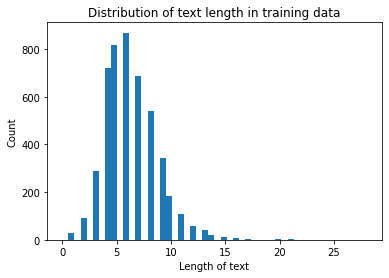

In [56]:
# Plotting the distribution of text length in the training data
plt.hist([len(x) for x in X_train_seq], bins=50)
plt.title('Distribution of text length in training data')
plt.xlabel('Length of text')
plt.ylabel('Count')
plt.show()

In [57]:
# Defining the LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_seq_len))
model.add(LSTM(units=128))
model.add(Dense(units=21, activation='softmax'))

In [58]:
# Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [59]:
# Training the model
history = model.fit(X_train_padded, y_train_encoded, validation_data=(X_test_padded, y_test_encoded), epochs=10, batch_size=128)

Epoch 1/10
38/38 [==============================] - 9s 173ms/step - loss: 1.3901 - accuracy: 0.7398 - val_loss: 0.8627 - val_accuracy: 0.7900
Epoch 2/10
38/38 [==============================] - 7s 181ms/step - loss: 0.9474 - accuracy: 0.7584 - val_loss: 0.8267 - val_accuracy: 0.7900
Epoch 3/10
38/38 [==============================] - 6s 154ms/step - loss: 0.8058 - accuracy: 0.7704 - val_loss: 0.5721 - val_accuracy: 0.8313
Epoch 4/10
38/38 [==============================] - 6s 164ms/step - loss: 0.5564 - accuracy: 0.8531 - val_loss: 0.3686 - val_accuracy: 0.8775
Epoch 5/10
38/38 [==============================] - 6s 157ms/step - loss: 0.3438 - accuracy: 0.9096 - val_loss: 0.2164 - val_accuracy: 0.9300
Epoch 6/10
38/38 [==============================] - 6s 169ms/step - loss: 0.2933 - accuracy: 0.9129 - val_loss: 0.2187 - val_accuracy: 0.9362
Epoch 7/10
38/38 [==============================] - 6s 149ms/step - loss: 0.2007 - accuracy: 0.9390 - val_loss: 0.1573 - val_accuracy: 0.9550
Epoch 

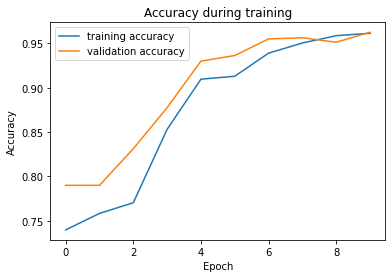

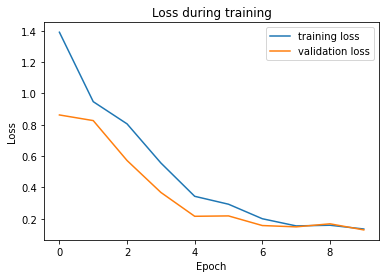

In [60]:
# Plotting the accuracy and loss during training
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [61]:
# Evaluating the model
_, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print('Accuracy:', accuracy)

25/25 [==============================] - 1s 22ms/step - loss: 0.1294 - accuracy: 0.9625
Accuracy: 0.9624999761581421
